In [7]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
import rpy2
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster import hierarchy
from math import sin,cos,pi
import scipy 

import seaborn as sns

folder_path = './datas/orihy/'
folder_path2 = './datas/orihyp/'
pcanum = 20
tempnum = 200

In [8]:
def rotate_spots(grid,spots,theta=0,translation=0,center_correction=0,figsize=(5,5),plot=True):
    grid = grid.copy() + center_correction
    spots = spots.copy() + center_correction
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    rotated_spots = np.array([R.dot(spots[i]) for i in range(len(spots))])
    rotated_spots += translation

    new_spots = grid[np.argmin(scipy.spatial.distance.cdist(rotated_spots,grid),axis=1)]

    grid -= center_correction
    spots -= center_correction
    rotated_spots -= center_correction
    new_spots -= center_correction

    seen = {}
    mapping = []
    for i in range(len(new_spots)):
        if tuple(new_spots[i]) in seen: continue
        seen[tuple(new_spots[i])] = 1
        mapping.append(i)

    if plot:
        fig = plt.figure(figsize=figsize)
        sns.scatterplot(x = grid[:,0],y = grid[:,1],linewidth=0,s=100, marker=".",alpha=0.2,color='blue')
        sns.scatterplot(x = rotated_spots[:,0],y = rotated_spots[:,1],linewidth=0,s=100, marker=".",color='red')
        sns.scatterplot(x = new_spots[:,0],y = new_spots[:,1],linewidth=0,s=100, marker=".",color='green')
        plt.show()

    return new_spots,mapping

def simulate_spatial(adata, rotation_angle):
    adata_sim = adata.copy()
    grid_size = 800
    layer_grid = np.array([[x,y] for x in range(grid_size) for y in range(grid_size)])
    new_spots, mappings = rotate_spots(layer_grid, adata.obsm['spatial'], center_correction=-15, theta= rotation_angle)
    adata_sim.obsm['spatial'] = new_spots
    return adata_sim[mappings, :], mappings

In [9]:
def simulate_gene_exp(adata, pc = 0.25, factor = 1):
    """
    Adds noise to gene expression data. The rows are simulated according to a Multinomial distribution, 
    with the total counts per spot drawn from a Negative Binomial Distribution.
    param: pc- Pseudocount to be added to dataframe
    param: factor - amount by which we scale the variance (to increase noise)
    """
    adata_sim = adata.copy()
    df = pd.DataFrame(adata_sim.X.toarray())
    # add pseudocounts 
    alpha = df.copy().to_numpy() + pc

    # get vector of total counts per spot
    n = df.sum(axis=1).to_numpy()

    # Simulate total counts using negative binomial
    mean = np.mean(n)
    var = np.var(n)*factor
    n = sample_nb(mean, var, len(n)).astype(int)

    # Reassign zero counts so we don't divide by 0 in future calcuation
    n[n == 0] = 1

    # convert to float
    alpha = np.array(alpha, dtype=np.float64)
    n = np.array(n, dtype=np.float64)

    # convert rows to unit vectors
    alpha = alpha/alpha.sum(axis=1)[:, None]

    dist = np.empty(df.shape)
    for i in range(alpha.shape[0]):
        dist[i] = np.random.multinomial(n[i], alpha[i])
    new_df = pd.DataFrame(dist, index= df.index, columns= df.columns)
    adata_sim.X = new_df
    return adata_sim

def sample_nb(m, v, n = 1):
    """
    param: m - mean
    param: v - variance
    param: n - number of samples
    return: random sample from negative binomial distribution
    """
    r = m**2/(v - m)
    p = m/v
    samples = np.random.negative_binomial(r, p, n)
    return samples

In [10]:
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
adata_subset = datas[:tempnum,:]
adata_subset
sc.write('./datas/nature/adata_subset.h5',adata_subset)

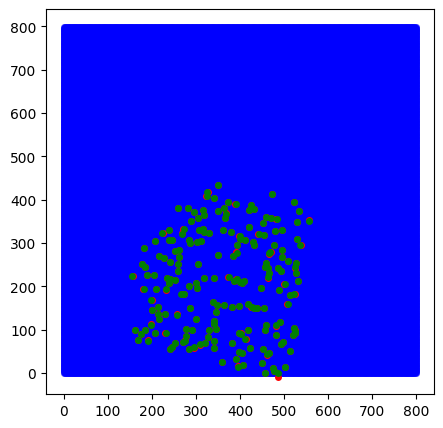

In [11]:
datas = sc.read_h5ad("./datas/nature/adata_subset.h5")
datas = simulate_gene_exp(datas)
datas,m = simulate_spatial(datas,-pi/12);

count_sub = datas.to_df()
xy_coords = pd.DataFrame(datas.obsm['spatial'],columns=['imagerow','imagecol'],index= datas.obs.index)
xy_coords.to_csv(folder_path+"xy.csv")
datas.obs.to_csv(folder_path+'meta_data.csv');
count_sub.T.to_csv(folder_path+"gene.csv")
count_sub.to_csv(folder_path+"datas.data",header=None);
count_sub.to_csv(folder_path+"datas.csv");

./datas/orihy/datas.data length:200
Generating all pairs superset


100%|██████████| 1563/1563 [01:01<00:00, 25.29ex/s, loss=1.670165] 


	 Epoch 0 | average train loss: 1.633956
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.53ex/s, loss=1.639381] 


	 Epoch 1 | average train loss: 1.622319
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.30ex/s, loss=1.564773] 


	 Epoch 2 | average train loss: 1.620792
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.58ex/s, loss=1.561027] 


	 Epoch 3 | average train loss: 1.620655
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.56ex/s, loss=1.574744] 


	 Epoch 4 | average train loss: 1.619650
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.31ex/s, loss=1.632675] 


	 Epoch 5 | average train loss: 1.619004
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.28ex/s, loss=1.611286] 


	 Epoch 6 | average train loss: 1.618620
Optimization finished.


100%|██████████| 1563/1563 [01:03<00:00, 24.67ex/s, loss=1.645635] 


	 Epoch 7 | average train loss: 1.618395
Optimization finished.


100%|██████████| 1563/1563 [01:02<00:00, 25.02ex/s, loss=1.586335] 


	 Epoch 8 | average train loss: 1.618459
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 25.86ex/s, loss=1.606965] 


	 Epoch 9 | average train loss: 1.618339
Optimization finished.


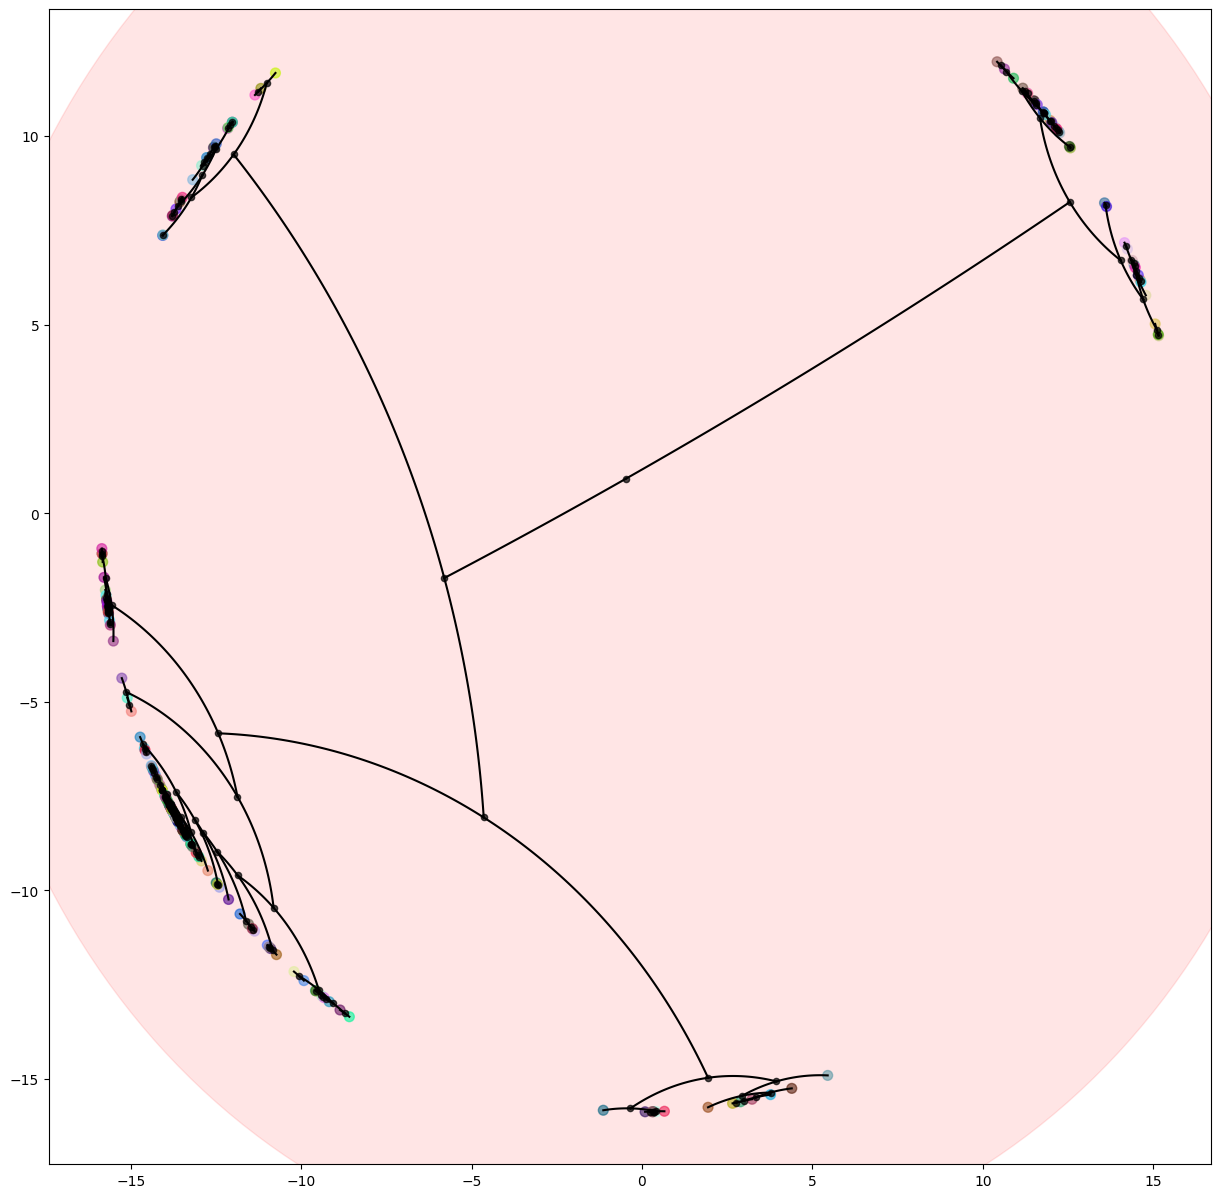

In [12]:
get_Hyper_tree(folder_path+'datas.data',1,count_sub.shape[1]+1,0,10,model_path=None,save_path=folder_path,c=-1)


In [13]:
# adata1 = datas.to_df()
# similarity_matrix = 1 - cosine_similarity(adata1)
# n=len(similarity_matrix);
# Z = hierarchy.linkage(similarity_matrix, 'ward')

# nodes1 = [node(name=str(i),son=[]) for i in range(2*n-1)]
# for i in range(n):
#     nodes1[i].value = adata1.iloc[i].to_numpy()
# for i in range(n-1):
#     nodes1[n+i].son.append(nodes1[int(Z[i][0])])
#     nodes1[n+i].son.append(nodes1[int(Z[i][1])])
#     nodes1[n+i].value = nodes1[n+i].son[0].value  + nodes1[n+i].son[1].value
#     nodes1[n+i].value /=2


In [14]:
datas = sc.read_h5ad("./datas/nature/adata_subset.h5")

count_sub = datas.to_df()
xy_coords = pd.DataFrame(datas.obsm['spatial'],columns=['imagerow','imagecol'],index= datas.obs.index)
xy_coords.to_csv(folder_path2+"xy.csv")
datas.obs.to_csv(folder_path2+'meta_data.csv');
count_sub.T.to_csv(folder_path2+"gene.csv")
count_sub.to_csv(folder_path2+"datas.data",header=None);
count_sub.to_csv(folder_path2+"datas.csv");

In [15]:
count_sub.shape[1]

9948

./datas/orihyp/datas.data length:200
Generating all pairs superset


100%|██████████| 1563/1563 [01:01<00:00, 25.60ex/s, loss=1.880449] 


	 Epoch 0 | average train loss: 1.876872
Optimization finished.


100%|██████████| 1563/1563 [01:01<00:00, 25.40ex/s, loss=1.885633] 


	 Epoch 1 | average train loss: 1.870654
Optimization finished.


100%|██████████| 1563/1563 [00:59<00:00, 26.19ex/s, loss=1.836428] 


	 Epoch 2 | average train loss: 1.869662
Optimization finished.


100%|██████████| 1563/1563 [00:59<00:00, 26.18ex/s, loss=1.846960] 


	 Epoch 3 | average train loss: 1.869274
Optimization finished.


100%|██████████| 1563/1563 [00:59<00:00, 26.27ex/s, loss=1.859673] 


	 Epoch 4 | average train loss: 1.868864
Optimization finished.


100%|██████████| 1563/1563 [00:59<00:00, 26.11ex/s, loss=1.856070] 


	 Epoch 5 | average train loss: 1.868597
Optimization finished.


100%|██████████| 1563/1563 [00:59<00:00, 26.11ex/s, loss=1.853251] 


	 Epoch 6 | average train loss: 1.868473
Optimization finished.


100%|██████████| 1563/1563 [00:59<00:00, 26.10ex/s, loss=1.895562] 


	 Epoch 7 | average train loss: 1.868455
Optimization finished.


100%|██████████| 1563/1563 [01:00<00:00, 26.00ex/s, loss=1.845177] 


	 Epoch 8 | average train loss: 1.868399
Optimization finished.


100%|██████████| 1563/1563 [00:59<00:00, 26.17ex/s, loss=1.860744] 


	 Epoch 9 | average train loss: 1.868375
Optimization finished.


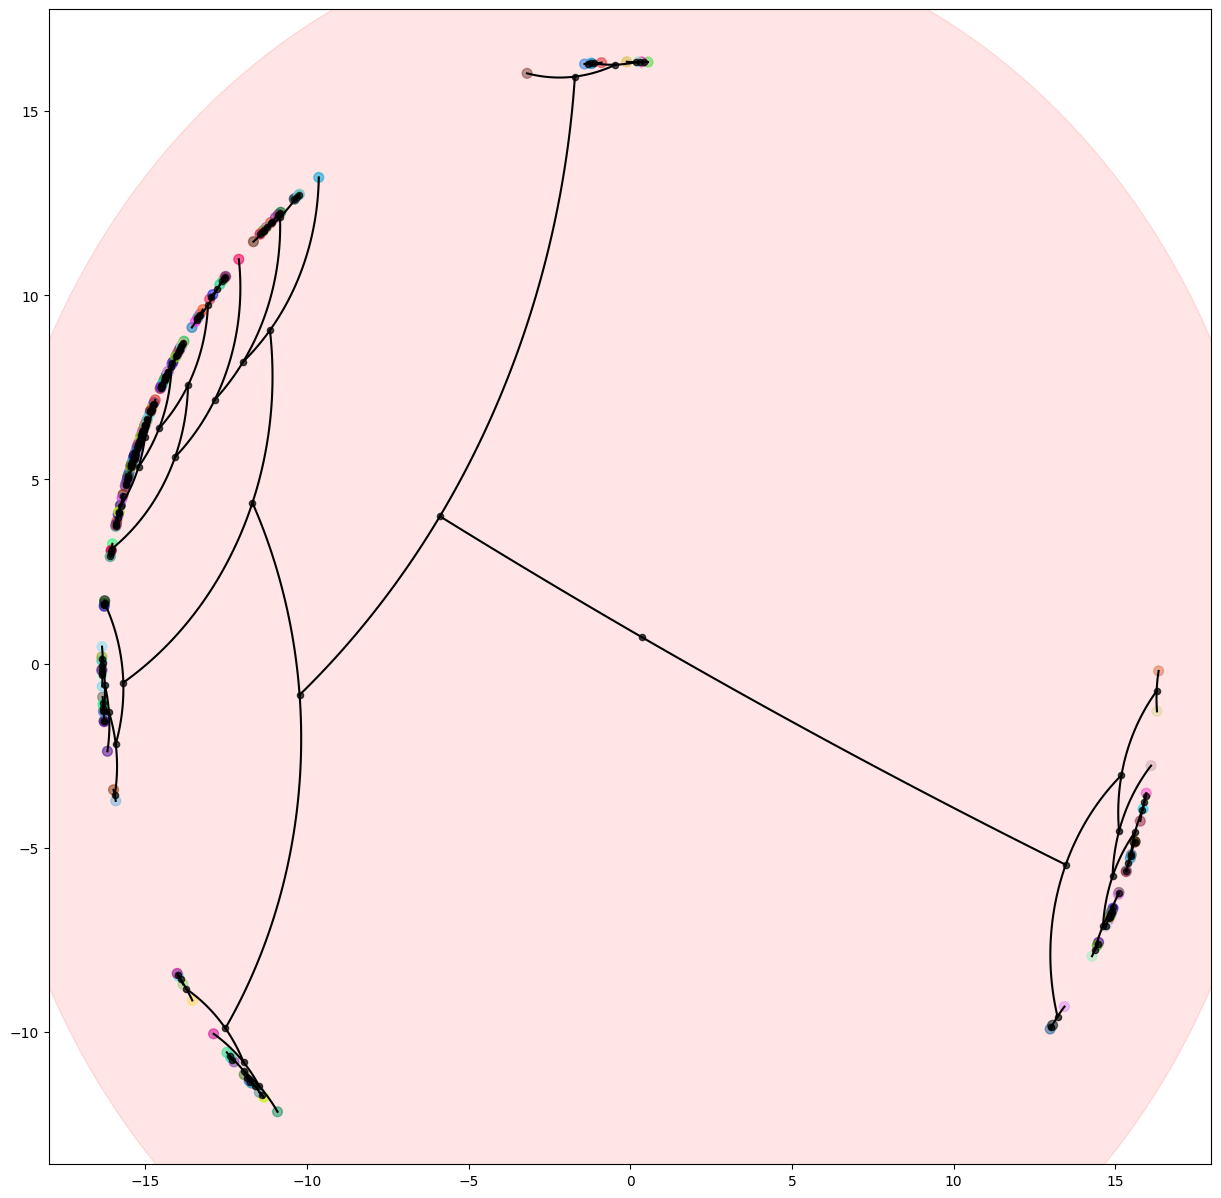

In [16]:
get_Hyper_tree(folder_path2+'datas.data',1,count_sub.shape[1]+1,0,10,model_path=None,save_path=folder_path2,c=-1)


In [17]:
nodes2,n2 = build_hyper_tree(folder_path2)
show_tree(nodes2[0]).show_fig()

In [18]:
nodes1,n1 = build_hyper_tree(folder_path)
# show_tree(nodes1[0]).show_fig()
nodes2,n2 = build_hyper_tree(folder_path2)
# show_tree(nodes2[0]).show_fig()
T=tree_alignment(nodes1[0],nodes2[0],1);
minn = T.run_alignment();
T.show_ans();
ans = T.get_ans()
G=show_graph(ans,nodes1[0],nodes2[0]);
# G.show_fig()
print("average cost for one node:{}".format(minn/(n1+n2)))

The mininum cost for alignment is 472.30305043026533
The alignment edges list is [('398', '398'), ('397', '397'), ('396', '396'), ('394', '391'), ('393', '375'), ('347', '353'), ('339', '301'), ('258', '155'), ('97', '138'), ('135', '60'), ('110', '112'), ('392', '382'), ('386', '377'), ('384', '372'), ('380', '368'), ('361', '348'), ('345', '306'), ('163', '178'), ('159', '14'), ('75', '194'), ('121', '341'), ('181', '338'), ('81', '159'), ('188', '99'), ('390', '392'), ('387', '384'), ('385', '383'), ('377', '380'), ('376', '373'), ('369', '371'), ('357', '366'), ('316', '365'), ('279', '327'), ('130', '135'), ('122', '187'), ('141', '331'), ('70', '70'), ('340', '364'), ('335', '351'), ('328', '307'), ('327', '249'), ('192', '224'), ('91', '241'), ('10', '10'), ('303', '334'), ('236', '300'), ('220', '298'), ('179', '258'), ('43', '120'), ('94', '1'), ('198', '290'), ('325', '350'), ('322', '346'), ('314', '315'), ('256', '139'), ('39', '93'), ('296', '337'), ('294', '303'), ('151',

In [21]:
all = 200;
count =0;
for i in range(200):
    if(ans.__contains__( (str(i),str(i)) ) ):
        count +=1
print(count/all);

0.05


In [24]:
G.show_fig()
